In [89]:
import json, requests
import pandas as pd
from tqdm import tqdm
import time
import numpy as np
import geopandas as geopd
import warnings
import folium as fl
from shapely import wkt
from shapely.geometry import Point, MultiPolygon


from sklearn.cluster import KMeans 
from yellowbrick.cluster import KElbowVisualizer

import plotly.express as px


warnings.filterwarnings('ignore')

## Business Understanding

### Problem Framing

## Getting data - Stage 1

In [5]:
def get_geo_data():
        
    print('> Creating the geo_dataframe.')
    
    geo_df = geopd.read_file('https://data.cityofnewyork.us/api/geospatial/d3qk-pfyz?method=export&format=GeoJSON')
    geo_df['centroid_gpd'] = geo_df.geometry.centroid
    geo_df['lat_long'] = 0
    
    print('> Getting the centroids coordinates (lat/long).')
    
    time.sleep(0.7)
    
    for i in tqdm(range(len(geo_df)),ncols=150):
        
        centroid_lat_long = np.array(geo_df.centroid_gpd[i])
        geo_df.loc[i,'lat_long'] = [str(centroid_lat_long[1])+','+str(centroid_lat_long[0])]
    
    print('> Done.')
    
    return geo_df

def get_foursquare_search_data(location):

    params = dict(
        client_id='UTCC2TLL2HALAQM2CAP3UK4SPVA4PSJFP32OW3WKD0PJAFLF',
        client_secret='TMRMFTUYEWR3E5ISBAGFIXX10FZE0TVVSPL5LPRLUWSQZEAW',
        ll = location,
        radius = 5000,
        limit = 100,
        v = '20191122',
        intent='browse',
        categoryId = '4bf58dd8d48988d1ca941735')
    
    url = 'https://api.foursquare.com/v2/venues/search?'
    pizzeria_data = requests.get(url = url, params= params)
    
    if pizzeria_data.ok:
        
        #return pizzeria_data.json()['response']['venues']
        return pd.io.json.json_normalize(pizzeria_data.json()['response']['venues'])
    
    else:
        
        raise Exception('Could not get the data: ',pizzeria_data.status_code)
        
        
def get_pizzerias_from_nta_centroids(centroids):
    
    pizza_nta = []
        
    for centroid in tqdm(centroids):
        
        data = pizza_nta.append(get_foursquare_search_data(location=centroid))
    
    df = pd.DataFrame()
        
    for i in tqdm(range(len(pizza_nta))):
        df = pd.concat([df,pd.DataFrame.from_dict(pizza_nta[i])])
        
    df.reset_index(drop=True,inplace=True)    
    
    return df

In [6]:
## getting the nta data from nyc open data

nyc_nta = get_geo_data()

## dropping columns that will not need

nyc_nta.drop(['shape_area','shape_leng','borocode','countyfips'],axis=1,inplace=True)

> Creating the geo_dataframe.
> Getting the centroids coordinates (lat/long).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 1508.32it/s]

> Done.


In [7]:
## inspecting the geodataframe [1]

nyc_nta.head()

,ntacode,ntaname,boroname,geometry,centroid_gpd,lat_long
0,BK43,Midwood,Brooklyn,"MULTIPOLYGON (((-73.94733 40.62917, -73.94687 ...",POINT (-73.95682 40.62092),"40.620924048798294,-73.95682460579987"
1,BK75,Bedford,Brooklyn,"MULTIPOLYGON (((-73.94193 40.70073, -73.94439 ...",POINT (-73.94991 40.69151),"40.691507495068585,-73.94990503494105"
2,BX40,Fordham South,Bronx,"MULTIPOLYGON (((-73.89138 40.86170, -73.89106 ...",POINT (-73.89954 40.85816),"40.858155196233064,-73.89953593415377"
3,BK88,Borough Park,Brooklyn,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",POINT (-73.98866 40.63095),"40.63094965540432,-73.98866123069084"
4,BK96,Rugby-Remsen Village,Brooklyn,"MULTIPOLYGON (((-73.90856 40.65210, -73.90945 ...",POINT (-73.92225 40.65236),"40.652364804102795,-73.92225097387865"


In [42]:
## inspecting the geodataframe [2]

nyc_nta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 6 columns):
ntacode         195 non-null object
ntaname         195 non-null object
boroname        195 non-null object
geometry        195 non-null geometry
centroid_gpd    195 non-null geometry
lat_long        195 non-null object
dtypes: geometry(2), object(4)
memory usage: 9.3+ KB


In [44]:
## inspecting the geodataframe [3]

nyc_nta.isna().sum()

ntacode         0
ntaname         0
boroname        0
geometry        0
centroid_gpd    0
lat_long        0
dtype: int64

In [46]:
## using the lat_long column to request the search API from foursquare

df = get_pizzerias_from_nta_centroids(nyc_nta.lat_long)

100%|██████████| 195/195 [00:03<00:00, 60.59it/s]


In [47]:
## inspecting the pizzeria data [1]

df.head()

,categories,delivery.id,delivery.provider.icon.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.name,delivery.url,hasPerk,id,location.address,...,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",1148888,/delivery_provider_seamless_20180129.png,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",seamless,https://www.seamless.com/menu/lb-spumoni-garde...,False,49d006ccf964a520f85a1fe3,2725 86th St,...,"[2725 86th St (at W 10th St), Brooklyn, NY 112...","[{'label': 'display', 'lat': 40.59457745537681...",40.594577,-73.981458,NaN,11223,NY,L&B Spumoni Gardens,v-1574765059,94425361
1,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",1035645,/delivery_provider_seamless_20180129.png,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",seamless,https://www.seamless.com/menu/di-fara-pizza-14...,False,40be6a00f964a520c4001fe3,1424 Avenue J,...,"[1424 Avenue J (at E 15th St), Brooklyn, NY 11...","[{'label': 'display', 'lat': 40.62513471122533...",40.625135,-73.961479,NaN,11230,NY,Di Fara Pizza,v-1574765059,95765712
2,"[{'id': '4bf58dd8d48988d11e941735', 'name': 'C...",NaN,NaN,NaN,NaN,NaN,NaN,False,563580bd498e59191f37606e,705 Flatbush Ave,...,"[705 Flatbush Ave (Parkside And Winthrop), Bro...","[{'label': 'display', 'lat': 40.65591812487629...",40.655918,-73.959928,NaN,11225,NY,Parkside,v-1574765059,NaN
3,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",751754,/delivery_provider_seamless_20180129.png,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",seamless,https://www.seamless.com/menu/papa-johns-3408-...,False,4b64e55af964a52031d82ae3,601 Rogers Ave,...,"[601 Rogers Ave (Winthrop St.), Brooklyn, NY 1...","[{'label': 'display', 'lat': 40.65706260104479...",40.657063,-73.952911,NaN,11225,NY,Papa John's Pizza,v-1574765059,NaN
4,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",NaN,NaN,NaN,NaN,NaN,NaN,False,4baec97df964a520fed73be3,1324 Avenue J,...,"[1324 Avenue J (at E 14th St), Brooklyn, NY 11...","[{'label': 'display', 'lat': 40.62505248036124...",40.625052,-73.962342,NaN,11230,NY,Pizza Time,v-1574765059,NaN


In [48]:
## inspecting the pizzeria data [2]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7882 entries, 0 to 7881
Data columns (total 25 columns):
categories                       7882 non-null object
delivery.id                      3634 non-null object
delivery.provider.icon.name      3634 non-null object
delivery.provider.icon.prefix    3634 non-null object
delivery.provider.icon.sizes     3634 non-null object
delivery.provider.name           3634 non-null object
delivery.url                     3634 non-null object
hasPerk                          7882 non-null bool
id                               7882 non-null object
location.address                 7617 non-null object
location.cc                      7882 non-null object
location.city                    7853 non-null object
location.country                 7882 non-null object
location.crossStreet             5021 non-null object
location.distance                7882 non-null int64
location.formattedAddress        7882 non-null object
location.labeledLatLngs         

In [49]:
## inspecting the pizzeria data [3]

df.isna().sum()

categories                          0
delivery.id                      4248
delivery.provider.icon.name      4248
delivery.provider.icon.prefix    4248
delivery.provider.icon.sizes     4248
delivery.provider.name           4248
delivery.url                     4248
hasPerk                             0
id                                  0
location.address                  265
location.cc                         0
location.city                      29
location.country                    0
location.crossStreet             2861
location.distance                   0
location.formattedAddress           0
location.labeledLatLngs             0
location.lat                        0
location.lng                        0
location.neighborhood            7474
location.postalCode               163
location.state                      0
name                                0
referralId                          0
venuePage.id                     6090
dtype: int64

In [51]:
## saving the pizzerias data for further use

df.to_csv('data/raw_venues_data.csv',index=False)

In [52]:
## saving the nta data from further use. 

## Obs.: I've tried saving as a geojson but I couldn't due to some error,
## I'm saving as csv and later i'll need to treat the geometry column and recreate the centroid data


nyc_nta.to_csv('data/raw_nta_data.csv',index=False)

In [57]:
del nyc_nta
del df

## Data Prep - Stage 1

In [69]:
def pre_process_raw(df):
    df.drop(['categories','delivery.id','delivery.provider.icon.name','delivery.provider.icon.prefix',
             'delivery.provider.icon.sizes','delivery.provider.name','delivery.url','hasPerk',
             'location.labeledLatLngs','referralId', 'venuePage.id','location.neighborhood'],axis=1,inplace=True)
    df.drop_duplicates('id',inplace=True)
    df.reset_index(drop=True,inplace=True)
    
    return df

def create_point_shape(df):
    
    points_series = []
    
    for value in zip(df['location.lng'],df['location.lat']):
        points_series.append(Point(value))
    
    df['location.point'] = points_series
    
    return df

def find_nta_name_from_pizzaria(df):
    
    geodf = geopd.read_file('https://data.cityofnewyork.us/api/geospatial/d3qk-pfyz?method=export&format=GeoJSON')
    
    choro = geodf.geometry
    
    df['ntaname'] = ''

    for i,point in enumerate(df['location.point']):
    
        for nta,poly in zip(geodf['ntaname'],geodf['geometry']):
        
            if poly.contains(point):
            
                df.loc[i,'ntaname'] = nta
    
    df.drop(df[df.ntaname == ''].index,axis=0,inplace=True)
    
    return df, [choro]

def create_folium_map(df,choros):
    
    m = fl.Map(location=['40.64554010471746','-73.90272819297329'],tiles='Stamen Toner')

    for choro in choros:
        fl.Choropleth(geo_data=choro,line_weight=2,line_color='red',fill_color='gray',name='NTAs').add_to(m)

    for lat,long,name,ntaname in zip(df['location.lat'],df['location.lng'],df['name'],df['ntaname']):
    
        popup = '**{}** in {}'.format(name,ntaname)
    
        fl.Marker(location=[str(lat),str(long)],popup=popup).add_to(m)    
    
    m.save('report/map_nta_pizzeiras.html')
    
def stage1_pre_processing(raw_venues_path):
    
    df = pd.read_csv(raw_venues_path)
    
    df = pre_process_raw(df)
    df = create_point_shape(df)
    df,choros = find_nta_name_from_pizzaria(df)
    create_folium_map(df,choros)
    
    return df.to_csv('data/treated_venues_data.csv',index=False)

In [70]:
stage1_pre_processing('data/raw_venues_data.csv')

## Getting data - Stage 2

In [75]:
def get_one_vanue_details(venue_id):
    
    CLIENT_ID = 'UTCC2TLL2HALAQM2CAP3UK4SPVA4PSJFP32OW3WKD0PJAFLF'
    CLIENT_SECRET = 'TMRMFTUYEWR3E5ISBAGFIXX10FZE0TVVSPL5LPRLUWSQZEAW'
    VERSION='20191109'
    
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    
    pizzaria_details = requests.get(url)
    
    if pizzaria_details.ok: 
        return pizzaria_details.json()['response']['venue']
    
    elif pizzaria_details.status_code == 429:
                
        CLIENT_ID = 'C3X5ON0TBSJM3TUPZ3WVFAE5LNF2ZC3SDAW2HFFCHLWBJX0D'
        CLIENT_SECRET = 'OJXPOLZZCOKJJ0VUGXCUJWNCXKOYFGQRZZMWVVYQ4KA2TLM5'
        VERSION='20191109'
    
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    
        pizzaria_details = requests.get(url)
    
        return pizzaria_details.json()['response']['venue']
    
    
    else:
        raise Exception('Could not get the data: ',pizzaria_details.status_code)

def get_all_venues_details(df):

    details_dict = {}

    for pizzaria in tqdm(df.id,ncols=150):
        details_dict[pizzaria] = get_one_vanue_details(pizzaria)
    
    return details_dict

In [78]:
treated_venues_dataframe = pd.read_csv('data/treated_venues_data.csv')

In [79]:
venues_details = get_all_venues_details(df)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 903/903 [13:01<00:00,  1.16it/s]


In [80]:
with open('data/raw_venues_details.json', 'w') as file:
    json.dump(venues_details,file)

## Data Prep - Stage 2

In [82]:
def get_likes(value):
    return int(value['count'])

def get_listed(value):
    return int(value['count'])

def get_price_tier(value):
    
    if value == 0:
        return 0
    else:
        return value['tier']

def get_stats(value):
    return int(value['tipCount'])


def pre_process(json_path):
    
    df = pd.read_json(json_path,orient='index')
    df.reset_index(inplace=True,drop=True)
    df.drop(['allowMenuUrlEdit','attributes','beenHere',
         'bestPhoto','categories','colors','contact',
         'createdAt','delivery','description','dislike',
         'hasMenu', 'hereNow','hierarchy','hours',
         'inbox','menu','ok','page','pageUpdates',
         'parent','photos','popular','ratingColor',
         'reasons', 'shortUrl','specials', 'storeId', 
         'timeZone', 'tips', 'url', 'venuePage', 'verified',
         'location'],axis = 1, inplace = True)
    df.price.fillna(0,inplace=True)
    
    df['likes'] = df.likes.apply(get_likes)
    
    df['listed'] = df.listed.apply(get_listed)
    
    df['price'] = df.price.apply(get_price_tier)
        
    df['stats'] = df.stats.apply(get_stats)
    
    df['rating'].fillna(0,inplace=True)
    df['ratingSignals'].fillna(0,inplace=True)
    
    return df.to_csv('data/treated_venues_details.csv')

In [84]:
pre_process('data/raw_venues_details.json')

## Data Prep - Stage 3

In [145]:
def pre_process_stage3(treated_venues_data,treated_venues_details):
    
    venues_data = pd.read_csv(treated_venues_data)
    venues_details = pd.read_csv(treated_venues_details)
    
    df = venues_data.merge(venues_details,left_on='id',right_on='id')
    df.drop(['name_y','location.distance'],axis=1,inplace=True)
    
    return df

def calculate_nta_scores(df):
    df.drop(['Unnamed: 0','price'],axis='columns',inplace=True)
    df_agg = df.groupby('ntaname').agg({'id':'count',
                           'likes':'mean',
                           'listed':'mean',
                           'rating':'mean',
                           'ratingSignals':'mean',
                           'stats':'mean'})
    
    df_agg['grading'] = df_agg.rating * df_agg.ratingSignals / max(df_agg.rating * df_agg.ratingSignals)
    df_agg['popularity'] = np.cbrt((df_agg.likes * df_agg.listed * df_agg.stats)) / max(np.cbrt((df_agg.likes * df_agg.listed * df_agg.stats)))
    df_agg['quantity'] = df_agg.id / max(df_agg.id)
    df_agg.reset_index(drop=False,inplace=True)
    df_agg.rename({'id':'number_of_pizzerias','index':'ntaname'},axis=1,inplace=True)
    
    return df_agg

In [146]:
df = calculate_nta_scores(pre_process_stage3('data/treated_venues_data.csv','data/treated_venues_details.csv'))

In [147]:
df.head()

,ntaname,number_of_pizzerias,likes,listed,rating,ratingSignals,stats,grading,popularity,quantity
0,Airport,16,9.875000,1.625000,3.356250,26.187500,9.437500,0.010351,0.009201,0.457143
1,Allerton-Pelham Gardens,5,18.800000,3.800000,5.600000,30.400000,7.400000,0.020050,0.013957,0.142857
2,Annadale-Huguenot-Prince's Bay-Eltingville,11,2.363636,0.272727,1.218182,1.818182,1.181818,0.000261,0.001577,0.314286
3,Arden Heights,2,6.500000,3.000000,3.850000,9.500000,3.500000,0.004308,0.007054,0.057143
4,Astoria,16,50.937500,56.812500,6.150000,74.250000,19.750000,0.053780,0.066491,0.457143


In [148]:
raw = pd.read_csv('data/raw_nta_data.csv')

In [149]:
treated_nta_data = raw.merge(df,left_on='ntaname',right_on='ntaname')

In [150]:
treated_nta_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174 entries, 0 to 173
Data columns (total 15 columns):
ntacode                174 non-null object
ntaname                174 non-null object
boroname               174 non-null object
geometry               174 non-null object
centroid_gpd           174 non-null object
lat_long               174 non-null object
number_of_pizzerias    174 non-null int64
likes                  174 non-null float64
listed                 174 non-null float64
rating                 174 non-null float64
ratingSignals          174 non-null float64
stats                  174 non-null float64
grading                174 non-null float64
popularity             174 non-null float64
quantity               174 non-null float64
dtypes: float64(8), int64(1), object(6)
memory usage: 21.8+ KB


In [151]:
treated_nta_data.to_csv('data/treated_nta_data.csv',index=False)

## Modeling & Evaluation

In [151]:
treated_nta_data = pd.read_csv('data/treated_nta_data.csv')

In [3]:
treated_nta_data.head()

,ntacode,ntaname,boroname,geometry,centroid_gpd,lat_long,number_of_pizzerias,likes,listed,rating,ratingSignals,stats,grading,popularity,quantity
0,BK43,Midwood,Brooklyn,MULTIPOLYGON (((-73.94732672160586 40.62916656...,POINT (-73.95682460579987 40.62092404879829),"40.620924048798294,-73.95682460579987",5,127.00,526.4,5.980,194.00,73.40,0.136631,0.293325,0.142857
1,BK75,Bedford,Brooklyn,MULTIPOLYGON (((-73.94193078816201 40.70072523...,POINT (-73.94990503494105 40.69150749506858),"40.691507495068585,-73.94990503494105",5,30.40,15.8,7.000,54.40,17.20,0.044848,0.034895,0.142857
2,BK88,Borough Park,Brooklyn,MULTIPOLYGON (((-73.9760493559142 40.631275905...,POINT (-73.98866123069084 40.63094965540432),"40.63094965540432,-73.98866123069084",4,6.25,2.0,3.575,10.25,4.25,0.004316,0.006489,0.114286
3,BK96,Rugby-Remsen Village,Brooklyn,MULTIPOLYGON (((-73.90855790522774 40.65209593...,POINT (-73.92225097387865 40.6523648041028),"40.652364804102795,-73.92225097387865",2,4.00,0.0,3.900,5.50,1.50,0.002526,0.000000,0.057143
4,QN52,East Flushing,Queens,MULTIPOLYGON (((-73.79493246234003 40.75779803...,POINT (-73.80729418195874 40.75410888687151),"40.754108886871514,-73.80729418195874",1,2.00,1.0,5.800,8.00,3.00,0.005465,0.003137,0.028571


In [4]:
X = treated_nta_data[['grading','popularity','quantity']]

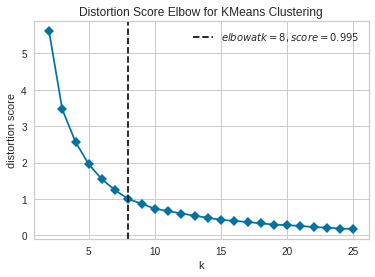

In [9]:
km = KMeans(n_jobs=-1,random_state=42,max_iter=5000)
viz = KElbowVisualizer(km, k=25,metric='distortion',timings=False)
viz.fit(X)
viz.show();

In [11]:
km_final = KMeans(n_clusters=8,random_state=42,max_iter=5000,n_jobs=-1,n_init=1000)
treated_nta_data['cluster'] = km_final.fit_predict(X)

In [76]:
count_per_cluster = treated_nta_data[['ntacode','cluster']].groupby('cluster',as_index=False).count()

In [77]:
count_per_cluster

,cluster,ntacode
0,0,90
1,1,21
2,2,6
3,3,1
4,4,14
5,5,2
6,6,5
7,7,35


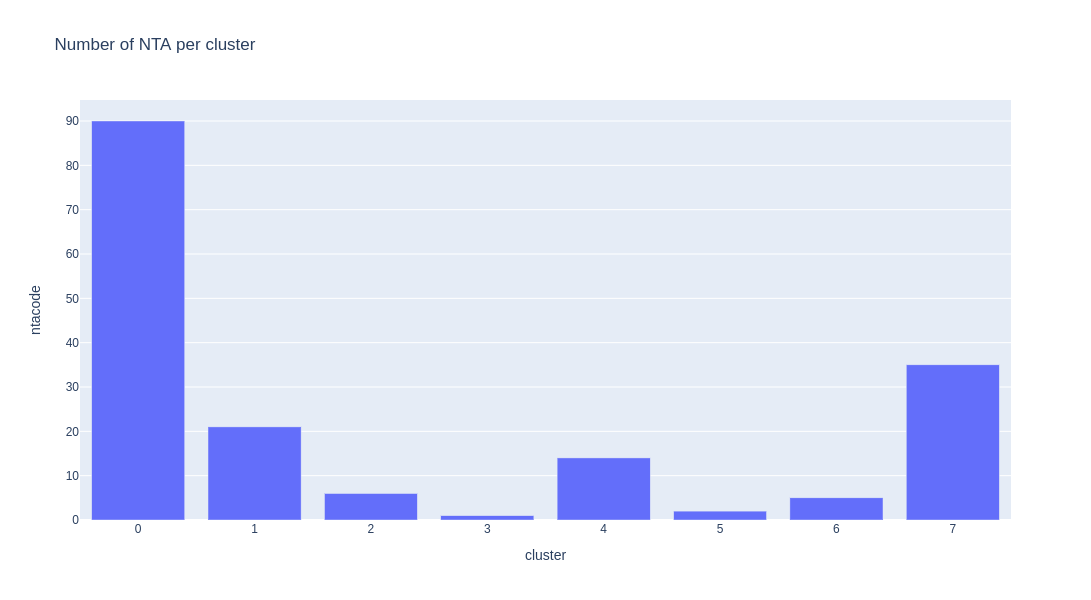

In [78]:
px.bar(count_per_cluster,x='cluster',y='ntacode',title='Number of NTA per cluster')

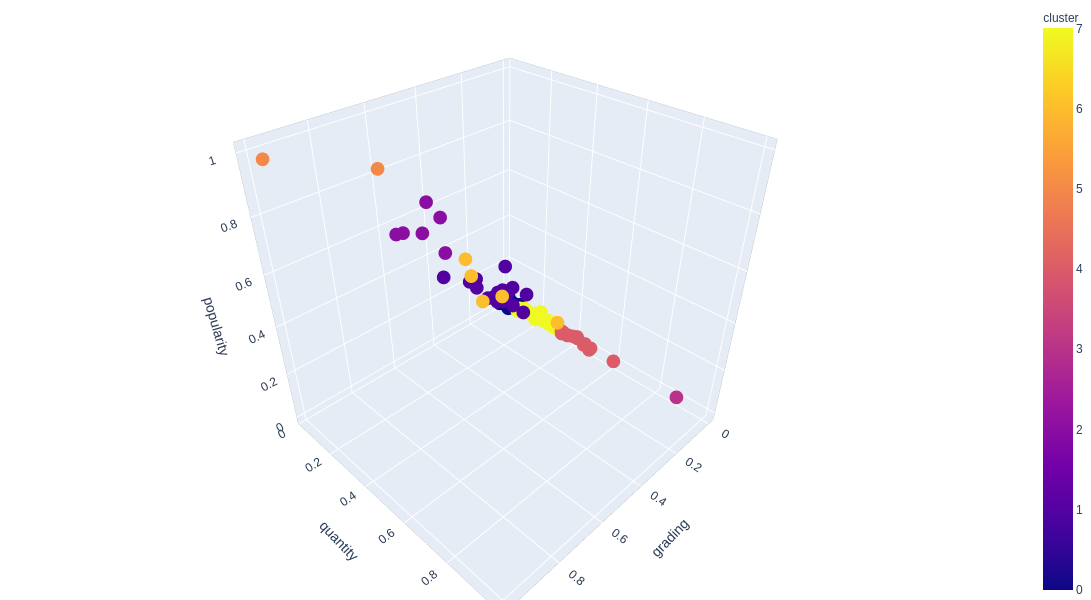

In [79]:
fig = px.scatter_3d(treated_nta_data,x='grading',y='quantity',z='popularity',color='cluster')
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

## Results

In [134]:
treated_nta_data['geometry'] = treated_nta_data['geometry'].apply(MultiPolygon)
treated_nta_data = geopd.GeoDataFrame(treated_nta_data,geometry='geometry')
treated_nta_data.crs = {'init' :'epsg:4326'}

In [150]:
m = fl.Map(location=['40.64554010471746','-73.90272819297329'],tiles='OpenStreetMap')
fl.raster_layers.TileLayer(tiles='Stamen Toner').add_to(m)

colors = ['']


for cluster in treated_nta_data['cluster'].unique():
    cluster_group = fl.map.FeatureGroup(name='Cluster {}'.format(cluster),colors='red') 
    cluster_group.add_child(fl.features.Choropleth(geo_data=treated_nta_data[treated_nta_data['cluster'] == cluster].geometry,colors='YlOrRd'))
    m.add_child(cluster_group)
    

fl.LayerControl().add_to(m)

m.save('report_map.html')